# Hydroshare Graph Explorer

Exploring the hydroshare graph leveraging off the wowk at https://derwen.ai/docs/kgl/ex6_1/


In [1]:
import kglab
from os.path import dirname
import os
import igraph as ig
import leidenalg as la
from networkx.algorithms import bipartite

In [2]:
ns = {
    "nom":  "http://example.org/#",
    "schema" : "https://schema.org/",
    "hydroshare": "https://www.hydroshare.org/",
    "skos": "http://www.w3.org/2004/02/skos/core#",
    "rdf": "http://www.w3.org/1999/02/22-rdf-syntax-ns#"
}

kg = kglab.KnowledgeGraph(
    name = "Hydroshare graph Sept 23rd 2021",
    base_uri = "https://www.hydroshare.org/",
    namespaces = ns,
    use_gpus=False   ## Need to turn off GPU here due to 
)

kg.load_rdf("./data/hydroshare_graph.ttl")

In [3]:
testnamespaces = {
    "nom":  "http://example.org/#",
    "wtm":  "http://purl.org/heals/food/",
    "ind":  "http://purl.org/heals/ingredient/",
    "skos": "http://www.w3.org/2004/02/skos/core#",
}

testkg = kglab.KnowledgeGraph(
    name = "A recipe KG example based on Food.com",
    base_uri = "https://www.food.com/recipe/",
    namespaces = testnamespaces,
    use_gpus=False
)

testkg.load_rdf("./data/recipes.ttl") ;

In [4]:
# ?s rdf:type <https://schema.org/Dataset>  .

testsparql = """
    SELECT ?subject ?object
    WHERE {
        ?subject rdf:type wtm:Recipe .
        ?subject wtm:hasIngredient ?object .
    }
    """

sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT *
  WHERE {
      ?s ?p ?o 
  }
"""

sparql2 = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>

SELECT ?subject ?object
  WHERE {
      ?subject rdf:type schema:Dataset  .
      ?subject schema:keywords ?object .
  }
  LIMIT 14000
"""

sparql2v2 = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>

SELECT ?subject ?object
  WHERE {
      ?s rdf:type schema:Dataset  .
      ?s schema:url ?subject  .
      ?s schema:keywords ?object .
  }
  """

sparql3 = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?s ?p ?o
  WHERE {
      BIND (<https://www.hydroshare.org/resource/aefabd0a6d7d47ebaa32e2fb293c9f8a#schemaorg> AS ?s)
      ?s ?p ?o
  }
  """

## What would a plot look like

In [5]:
import igraph as ig 

subgraph = kglab.SubgraphMatrix(kg, sparql2v2)
ig_graph = subgraph.build_ig_graph(ig.Graph())
component = ig_graph.components().subgraph(0)
partition = la.find_partition(component, la.ModularityVertexPartition)

KeyboardInterrupt: 

In [ ]:
ig_graph.vs[0].attributes()


In [ ]:
ig.plot(partition, bbox=(600, 500), vertex_label_size=10, margin=50)


##  Inspiration

This is from https://derwen.ai/docs/kgl/ex6_1/

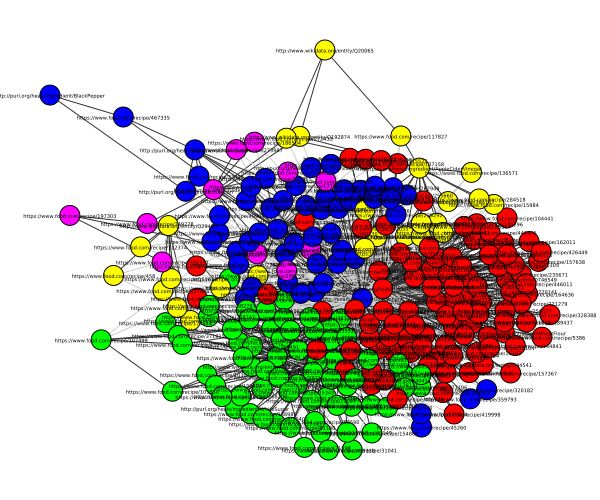

In [5]:
import igraph as ig

testsubgraph = kglab.SubgraphMatrix(testkg, testsparql)
testig_graph = testsubgraph.build_ig_graph(ig.Graph())

# testig_graph.vs[0].attributes()

testcomponent = testig_graph.components().subgraph(0)
testpartition = la.find_partition(testcomponent, la.ModularityVertexPartition)

ig.plot(testpartition, bbox=(600, 500), vertex_label_size=5, margin=50)


## Review
Let's take a look at one our resources to get a feel for the data in a record

In [ ]:
dfres = kg.query_as_df(sparql3,  bindings=None, simplify=True, pythonify=False)
dfres.head(len(dfres))

In [ ]:
import pandas as pd
# pd.set_option("max_rows", None)

df = kg.query_as_df(sparql2v2,  bindings=None, simplify=True, pythonify=False)
df.object = df.object.str.strip('"')
df.head()

In [ ]:
df.value_counts("object")

In [ ]:
subgraph = kglab.SubgraphMatrix(kg, sparql2v2)
ig_graph = subgraph.build_ig_graph(ig.Graph())

In [ ]:
count = ig_graph.vcount()
sample = ig_graph.vs[1000].attributes()

print("Found {} with a sample looking like {}".format(count, sample))

In [ ]:
# save out if you want to
with open("tmp.graphml", "w") as f:
    ig_graph.write_graphml(f)

## Community detection

In [ ]:
component = ig_graph.components().subgraph(0)
partition = la.find_partition(component, la.ModularityVertexPartition)

In [ ]:
# do not try..   memory issues
ig.plot(partition, bbox=(800, 600), vertex_label_size=8, margin=50)

## NetworkX exploring

In [ ]:
import networkx as nx

sparql3 = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
SELECT ?subject ?object
WHERE { 
  ?subject a <https://schema.org/Dataset> .
  ?subject <https://schema.org/creator> ?creator .
  ?creator rdf:first ?o .
  ?o <https://schema.org/name> ?object
}
  """

subgraph = kglab.SubgraphMatrix(kg, sparql3)
nx_graph = subgraph.build_nx_graph(nx.DiGraph(), bipartite=True)